# Tema 2

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import numpy as np
from matplotlib import pyplot
import pickle
import pickle
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def preprocess(data):
  return data.float() / 255.0

In [3]:
kwargs={}
class Args():
  def __init__(self):
      self.batch_size = 64
      self.test_batch_size = 64
      self.epochs = 10
      self.lr = 3e-4
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(10000 / self.batch_size)
      self.cuda = True

args = Args()

use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
no_filters1 = 20
no_filter2 = 50
no_neurons1 = 500

Am pastrat functia de interpretare a setului de date din laboratorul 3, insa am folosit drep eticheta "no_cout" de aceasta data.

In [4]:
def get_large_dataset(path, max_batch_idx=100, shuffle=False,first_k=5000):
    with open(path,'rb') as handle:
        data = pickle.load(handle)
    np_dataset_large  = np.expand_dims(data['images'],1)[:first_k]
    np_dataset_no_count = data['no_count'].astype(np.int64)[:first_k]
  
  # show a couple of examples from the dataset
    print(f'np_dataset_large shape: {np_dataset_large.shape}')
    for ii in range(5):
        example = np_dataset_large[10+ii].reshape((100, 100))
        pyplot.figure()
        pyplot.imshow(example, cmap="gray")
  
  # create loader from the numpy tensors
    
    dataset_large, dataset_no_count = map(torch.Tensor, 
                (np_dataset_large, np_dataset_no_count))
    dataset_large = dataset_large.to(device)
    dataset_no_count = dataset_no_count.to(device)
    
    large_dataset = TensorDataset(dataset_large, dataset_no_count)
    large_data_loader = DataLoader(large_dataset, 
       batch_size=args.batch_size, shuffle=shuffle, drop_last=True)
    return large_data_loader

Intrucat cerinta a doua cere evaluarea unor modele atat pe setul intreg de date, cat si pe fragmente din acesta, am adaugat inca 2 instante de DataLoader, pentru 20% si respectiv 50% din date.

np_dataset_large shape: (5000, 1, 100, 100)
np_dataset_large shape: (1000, 1, 100, 100)
np_dataset_large shape: (1000, 1, 100, 100)
np_dataset_large shape: (2500, 1, 100, 100)


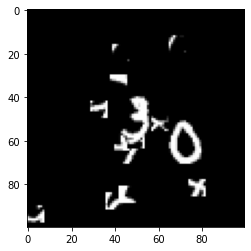

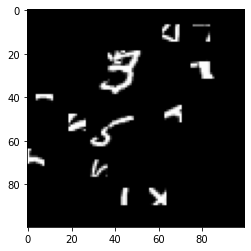

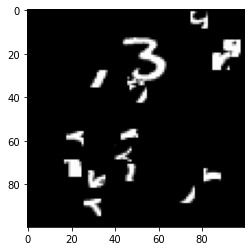

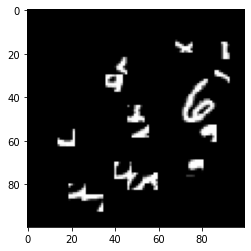

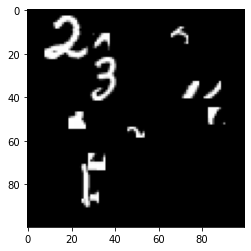

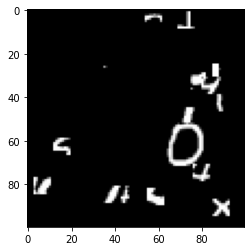

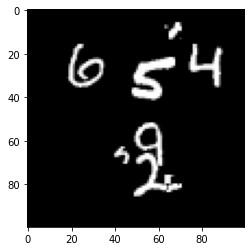

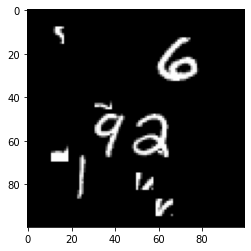

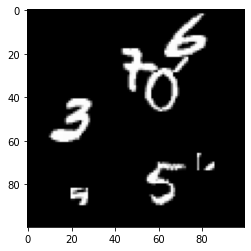

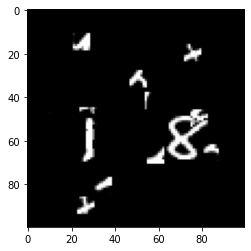

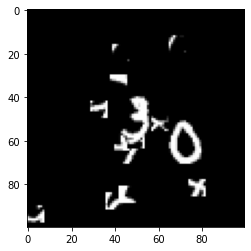

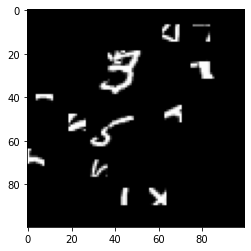

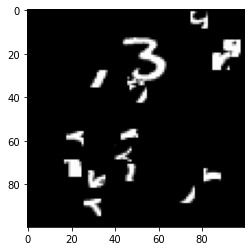

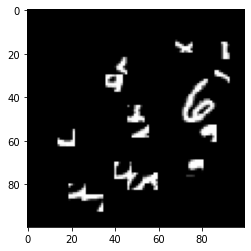

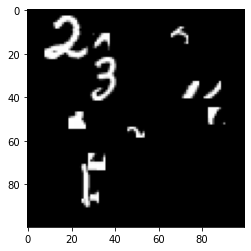

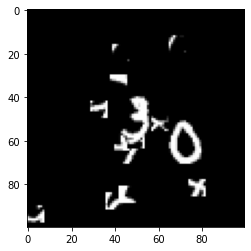

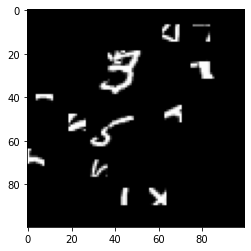

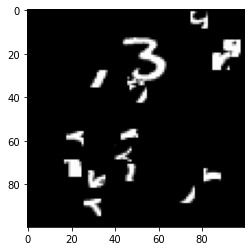

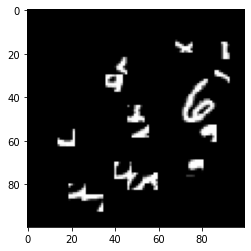

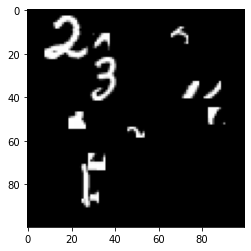

In [5]:
path_train = 'assignment2/mnist_count_train.pickle'
path_test = 'assignment2/mnist_count_test.pickle'


large_data_loader_train = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=5000)
large_data_loader_test = get_large_dataset(path_test,max_batch_idx=50)

large_data_loader_train_20 = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=1000)
large_data_loader_train_50 = get_large_dataset(path_train,max_batch_idx=50,shuffle=True, first_k=2500)

In [7]:
len(large_data_loader_train_50.dataset)

2500

## Metoda 1

Vom folosi modelul prezenntat in laboratorul 3 pentru a prezice cifre, antrenandu-l pe setul MNIST.
Pentru asta, am instalat MNIST local folosind pasii dintr-un tutorial, prin urmare am atasat MNIST si in arhiva.

Labels of the shown images: tensor([6, 1, 4, 0, 7])


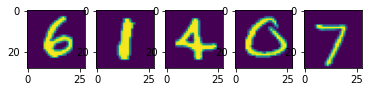

In [6]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./python-mnist/data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./python-mnist/data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=False,drop_last=True, **kwargs)

first_train_batch_imgs, first_train_batch_labels = next(iter(train_loader))
# set_trace()

f, axarr = pyplot.subplots(1,5)
for i in range(5):
  axarr[i].imshow(first_train_batch_imgs[i,0])
print(f'Labels of the shown images: {first_train_batch_labels[:5]}')

Am pastrat de asemenea si functiile de train si test asa cum au fost definite in laborator si am tratat problema in continuare ca pe o problema de regresie.

In [7]:
# define two functions, one for training the model and one for testing it
criterion = nn.CrossEntropyLoss()
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # put the data on the GPU
        data, target = data.to(device), target.to(device)
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        
        # obtain the predictions in the FORWARD pass of the network
        output = model(data)
        # compute average LOSS for the current batch
        loss = criterion(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        # BACKPROPAGATE the gradients
        loss.backward()
        # use the computed gradients to OPTIMISE the model
        optimizer.step()
        # print the training loss of each batch
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.array(all_losses).mean()

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # obtain the prediction by a forward pass
            output = model(data)
            # calculate the loss for the current batch and add it across the entire dataset
            test_loss += criterion(output, target) # sum up batch loss
            # compute the accuracy of the predictions across the entire dataset
            # get the most probable prediction
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1
    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter
    # print the Accuracy for the entire dataset
    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

Intai, folosim modelul din laborator pentru a recunoaste cifre din MNIST pe imagini de dimensiune 28x28.

In [8]:
no_filters1 = 20
no_filter2 = 50
no_neurons1 = 500
class CNN(nn.Module):
    # the init() is called a single time, when you create the model
    # so all the layers should be created here.
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_filters1, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fc1 = nn.Linear(in_features = 4 * 4 * no_filter2, out_features = no_neurons1)
        self.fc2 = nn.Linear(in_features = no_neurons1, out_features = 10)
    # the forward() is called at each iteration, so we only apply the already
    # created operations inside this function 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*no_filter2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306483
Train Epoch: 1 [9984/60000 (17%)]	Loss: 2.290544
Train Epoch: 1 [19968/60000 (33%)]	Loss: 2.253976
Train Epoch: 1 [29952/60000 (50%)]	Loss: 2.209204
Train Epoch: 1 [39936/60000 (67%)]	Loss: 2.162579
Train Epoch: 1 [49920/60000 (83%)]	Loss: 1.943042
Train Epoch: 1 [59904/60000 (100%)]	Loss: 1.577993

Test set: Average loss: 1.5148, Accuracy: (74%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.482976
Train Epoch: 2 [9984/60000 (17%)]	Loss: 1.114235
Train Epoch: 2 [19968/60000 (33%)]	Loss: 0.707629
Train Epoch: 2 [29952/60000 (50%)]	Loss: 0.564851
Train Epoch: 2 [39936/60000 (67%)]	Loss: 0.465791
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.498018
Train Epoch: 2 [59904/60000 (100%)]	Loss: 0.326499

Test set: Average loss: 0.3945, Accuracy: (89%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.365690
Train Epoch: 3 [9984/60000 (17%)]	Loss: 0.632450
Train Epoch: 3 [19968/60000 (33%)]	Loss: 0.364801
Train Epoch: 3 [29952/60000 (50%)]	Loss: 0.416871
Train Epoch: 3 [

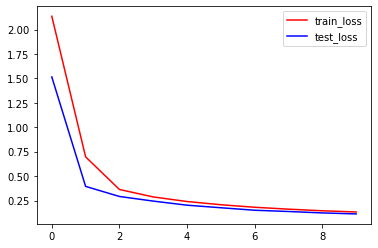

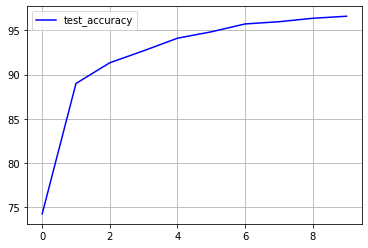

In [9]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.grid()
    pyplot.legend()

# move the model to the GPU (when available)
model = CNN().to(device)
# create an Stochastic Gradient Descent optimiser
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

losses_train = []
losses_test = []
accuracy_test = []
for epoch in range(1, args.epochs + 1):
# for epoch in range(1, 3):
    train_loss = train(args, model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(args, model, device, test_loader)
    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)

#plot the loss/accuracy    
pyplot.figure(1)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
pyplot.figure(2)
plot_loss(accuracy_test,'test_accuracy')

# save the final model
torch.save(model.state_dict(),"mnist_cnn.pt")

Folosim abordarea cu modelul complet-convolutional: transformam ultimele 2 straturi complet conectate in straturi convolutionale, cu ajutorul modelului din laborator:

In [10]:
# design the fully convolutional network   
# the first two conv layers should be the same as the original classification conv layers
# the last two conv layers should be transformed from the last two fully connected layers in the original network
class CNN_fully_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
        self.fully_conv2 = nn.Conv2d(no_neurons1,10, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.fully_conv1(x))
        x = self.fully_conv2(x)
        return F.log_softmax(x, dim=1)

Parametri:

In [11]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])


Ne folosim de parametri din modelul pentru MNIST pentru a initializa parametri din noul model:

In [12]:
PATH = "mnist_cnn.pt"
loaded_state_dict = torch.load(PATH)
model_fully_conv = CNN_fully_conv()

In [13]:
model_dict = {}
for key,val in loaded_state_dict.items():
  key = key.replace('fc','fully_conv')
  print(f'key: {key}')
  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filter2,4,4)
  if 'fully_conv2.weigh' in key:
    val = val.view(-1,no_neurons1,1,1)
  model_dict[key] = val
  
model_fully_conv.load_state_dict(model_dict)
model_fully_conv = model_fully_conv.to(device)

print(model_fully_conv.parameters)

key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias
<bound method Module.parameters of CNN_fully_conv(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fully_conv1): Conv2d(50, 500, kernel_size=(4, 4), stride=(1, 1))
  (fully_conv2): Conv2d(500, 10, kernel_size=(1, 1), stride=(1, 1))
)>


Calculam acuratetea astfel: modelul complet convolutional produce pentru fiecare intrare a setului de date un output de 10x19x19 (matrice de dimensiune 19x19 cu cate 10 canale reprezentand logaritm din probabilitati peste cele 10 posibilitati de cifre).  

Prelucrarea output-ului se face in felul urmator: din cele 10 canale vom lua valoarea maxima, deci cel mai mare logaritm din probabilitati. Astfel, ramanem cu un output de dimensiune 19x19. Sortam cele 19 $\cdot$ 19 valori descrescator. Cum stim ca intr-o imagine sunt maxim 5 numere, luam doar primele 5 valori si le supunem unei threshold ales experimental. Numarul de cifre din imagine reprezinta numarul de valori mai mari decat acel threshold dintre cele 5.  

Daca nicio valoare nu este mai mare decat acel threshold, consideram din oficiu ca fiind o singura cifra in imagine.

In [14]:
overall_accuracy = 0.0
for batch_idx, (large_imgs, target_number) in enumerate(large_data_loader_test):
    large_imgs = preprocess(large_imgs)
    out_prob_maps = model_fully_conv(large_imgs)
    # alegerea valorii maxime din fiecare canal
    max_values= torch.max(out_prob_maps.view(args.batch_size,10,-1),dim=1)[0]
    # alegerea primelor 5 cele mai mari valori dintre cele 19*19
    sorted_values = torch.sort(max_values, dim=1, descending=True).values[0:,0:5]
    final_outputs=[]
    # supunerea valorilor la un threshold
    for i in range(args.batch_size):
        number = (sorted_values[i]>=-0.01).sum().item()
        final_outputs.append(max(float(number),1))
    accuracy = (np.array(target_number.tolist()) == np.array(final_outputs)).sum()
    overall_accuracy+=accuracy
    
print(overall_accuracy/len(large_data_loader_test.dataset))

0.333


## Metoda 2

Alegem o noua arhitectura pentru a rezolva problema. Vom folosi ultima arhitectura aleasa anterior si ii vom face cateva mici ajustari:  
* conv2D + relu
* batch norm
* maxpooling2D
* conv2D + relu
* batch norm
* maxpooling2D
* fully_conv+relu
* fully_conv+relu
* liniar + relu
* droput
* liniar +relu

Folosim BatchNorm intre straturi pentru a standardiza datele.

Dropout-ul aplicat intre cele 2 straturi liniare presupune alegerea neuronilor care (nu) participa la antrenare cu o anumita probabilitate. Doar acei neuroni vor fi folositi atat in operatia de forward, cat si in backpropagation la un moment dat; acest procedeu ajuta reteaua pentru a nu ajunge sa foloseasca exclusiv un grup restrans de neuroni.

Intruca tratam problema ca pe o problema de regresie, vom alege ultima activare ReLU. De asemenea, asta ne va asigura ca valorile de la iesire nu vor fi niciodata negative.


In [15]:
# design the fully convolutional network   
# the first two conv layers should be the same as the original classification conv layers
# the last two conv layers should be transformed from the last two fully connected layers in the original network
class CNN_count(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
        self.batch_norm = nn.BatchNorm2d(no_filters1)
        self.conv2 = nn.Conv2d(no_filters1, no_filter2, 5, 1)
        self.batch_norm2 = nn.BatchNorm2d(no_filter2)
        self.fully_conv1  = nn.Conv2d(no_filter2,no_neurons1, 4)
        self.fully_conv2_new = nn.Conv2d(no_neurons1,10, 1)
        self.linear_loc = nn.Linear(19*19*10,64)
        self.final = nn.Linear(64,1)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, xb):
        x = xb.view(-1, 1, xb.shape[2], xb.shape[3])
        x = F.relu(self.conv1(x))
        x = self.batch_norm(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = self.batch_norm2(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.fully_conv1(x))
        x = self.fully_conv2_new(x).view(args.batch_size,-1)
        x= F.relu(self.linear_loc(x))
        x = self.dropout(x)
        out = F.relu(self.final(x))
        return out

In [16]:
def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.grid()
    pyplot.legend()

Folosim functiile de ``train_localisation`` si ``test_localisation`` din laborator si MSE pentru loss. In plus, adaugam si acuratetea: output-ul este corect daca modulul diferentei dintre acesta si clasa reala e

In [17]:
def train_localisation(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_losses = []
    accuracy = 0.0
    criterion = nn.MSELoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = preprocess(data)
        optimizer.zero_grad()
        output = model(data)
#         print(output)
#         print(target.shape)
        output = output.squeeze()
#         print(output.shape)
#         t = target.long()
        loss = criterion(output, target)
        loss.backward()
#         print(output[0:5], t[:5])
        accuracy += (np.abs((output-target).detach().cpu().numpy())<=0.5).sum().item()
        all_losses.append(loss.data.cpu().numpy())
        optimizer.step()
        if False and batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
    return np.array(all_losses).mean(), accuracy/len(train_loader.dataset)

In [18]:
def test_localisation(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    accuracy = 0.0
    criterion = nn.MSELoss()
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = preprocess(data)
            output = model(data)
            output = output.squeeze()
#             t = target.long()
            accuracy += (np.abs((output-target).detach().cpu().numpy())<=0.5).sum().item()
            test_loss += criterion(output, target).item()
            num_iter += 1
    test_loss /= num_iter

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss)),accuracy
    return test_loss, accuracy/len(test_loader.dataset)

Am parametrizat codul din laborator intr-o singura functie care va fi mai departe folosita pentru a antrena toate modelele:

In [19]:
def training_variants(my_model, device, train_data, test_data, optimizer, num_epochs):
    losses_train = []
    losses_test = []
    train_accuracy= []
    test_accuracy=[]
    for epoch in range(1, num_epochs):
        print(f'Pretrained epoch: {epoch}')
        # antrenarea modelului si testarea
        train_loss, acc= train_localisation(args, my_model, device, train_data, optimizer, epoch)
        test_loss, acc_test= test_localisation(args, my_model, device, test_data)
        # salvarea rezultatelor
        train_accuracy.append(acc)
        test_accuracy.append(acc_test)
        losses_train.append(train_loss)
        losses_test.append(test_loss)
        print("Train accuracy:", acc)
        print("Test accuracy:", acc_test)
    # intoarcerea tuturor metricilor
    return losses_train, losses_test, train_accuracy, test_accuracy

Definim 3 modele care vor fi antrenate pe proportii diferite din seturile de date si ai caror parametri nu sunt initializati cu ajutorul altui model.

In [26]:
# model ce va fi antrenat pe 20% din date
count_model_20 = CNN_count()
count_model_20 = count_model_20.to(device)

# model ce va fi antrenat pe 50% din date
count_model_50 = CNN_count()
count_model_50 = count_model_50.to(device) 

# model ce va fi antrenat pe toate datele
count_model_100 = CNN_count()
count_model_100 = count_model_100.to(device)

# optimizer pentru fiecare model
optimizer_count_20 = optim.SGD(
    count_model_20.parameters(), lr=2e-4, momentum=args.momentum)
optimizer_count_50 = optim.SGD(
    count_model_50.parameters(), lr=2e-4, momentum=args.momentum)
optimizer_count_100 = optim.SGD(
    count_model_100.parameters(), lr=2e-4, momentum=args.momentum)

# metricile evaluate
losses_train_20, losses_test_20, train_accuracy_20, test_accuracy_20 = training_variants(count_model_20, device, large_data_loader_train_20, large_data_loader_test, optimizer_count_20, 70)
losses_train_50, losses_test_50, train_accuracy_50, test_accuracy_50 = training_variants(count_model_50, device, large_data_loader_train_50, large_data_loader_test, optimizer_count_50, 70)
losses_train_100, losses_test_100, train_accuracy_100, test_accuracy_100 = training_variants(count_model_100, device, large_data_loader_train, large_data_loader_test, optimizer_count_100, 70)


Pretrained epoch: 1

Test set: Average loss: 10.1520

Train accuracy: 0.036
Test accuracy: 0.0
Pretrained epoch: 2

Test set: Average loss: 7.2646

Train accuracy: 0.205
Test accuracy: 0.202
Pretrained epoch: 3

Test set: Average loss: 3.3464

Train accuracy: 0.219
Test accuracy: 0.207
Pretrained epoch: 4

Test set: Average loss: 1.5827

Train accuracy: 0.247
Test accuracy: 0.233
Pretrained epoch: 5

Test set: Average loss: 1.4430

Train accuracy: 0.267
Test accuracy: 0.241
Pretrained epoch: 6

Test set: Average loss: 1.3596

Train accuracy: 0.277
Test accuracy: 0.271
Pretrained epoch: 7

Test set: Average loss: 1.2005

Train accuracy: 0.286
Test accuracy: 0.309
Pretrained epoch: 8

Test set: Average loss: 0.9472

Train accuracy: 0.328
Test accuracy: 0.323
Pretrained epoch: 9

Test set: Average loss: 0.8274

Train accuracy: 0.369
Test accuracy: 0.365
Pretrained epoch: 10

Test set: Average loss: 0.7911

Train accuracy: 0.407
Test accuracy: 0.396
Pretrained epoch: 11

Test set: Average 


Test set: Average loss: 0.1868

Train accuracy: 0.6868
Test accuracy: 0.733
Pretrained epoch: 18

Test set: Average loss: 0.1885

Train accuracy: 0.6824
Test accuracy: 0.732
Pretrained epoch: 19

Test set: Average loss: 0.1892

Train accuracy: 0.6652
Test accuracy: 0.724
Pretrained epoch: 20

Test set: Average loss: 0.2661

Train accuracy: 0.6816
Test accuracy: 0.626
Pretrained epoch: 21

Test set: Average loss: 0.2457

Train accuracy: 0.7048
Test accuracy: 0.645
Pretrained epoch: 22

Test set: Average loss: 0.1986

Train accuracy: 0.6616
Test accuracy: 0.698
Pretrained epoch: 23

Test set: Average loss: 0.4172

Train accuracy: 0.7072
Test accuracy: 0.486
Pretrained epoch: 24

Test set: Average loss: 0.2676

Train accuracy: 0.7204
Test accuracy: 0.619
Pretrained epoch: 25

Test set: Average loss: 0.1792

Train accuracy: 0.7184
Test accuracy: 0.729
Pretrained epoch: 26

Test set: Average loss: 0.4019

Train accuracy: 0.7272
Test accuracy: 0.484
Pretrained epoch: 27

Test set: Average l


Test set: Average loss: 0.2395

Train accuracy: 0.7618
Test accuracy: 0.647
Pretrained epoch: 33

Test set: Average loss: 0.1475

Train accuracy: 0.772
Test accuracy: 0.792
Pretrained epoch: 34

Test set: Average loss: 0.3004

Train accuracy: 0.7798
Test accuracy: 0.579
Pretrained epoch: 35

Test set: Average loss: 0.1381

Train accuracy: 0.7618
Test accuracy: 0.796
Pretrained epoch: 36

Test set: Average loss: 0.1331

Train accuracy: 0.7758
Test accuracy: 0.801
Pretrained epoch: 37

Test set: Average loss: 0.1555

Train accuracy: 0.7326
Test accuracy: 0.777
Pretrained epoch: 38

Test set: Average loss: 0.1682

Train accuracy: 0.788
Test accuracy: 0.755
Pretrained epoch: 39

Test set: Average loss: 0.2003

Train accuracy: 0.771
Test accuracy: 0.69
Pretrained epoch: 40

Test set: Average loss: 0.1775

Train accuracy: 0.7654
Test accuracy: 0.731
Pretrained epoch: 41

Test set: Average loss: 0.1281

Train accuracy: 0.7902
Test accuracy: 0.811
Pretrained epoch: 42

Test set: Average loss:

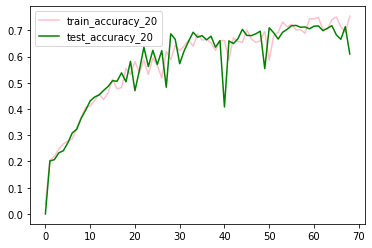

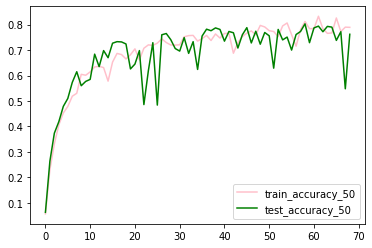

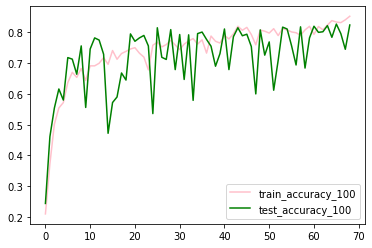

In [29]:
pyplot.figure(1)
plot_loss(train_accuracy_20,'train_accuracy_20','pink')
plot_loss(test_accuracy_20,'test_accuracy_20','green')
pyplot.figure(2)
plot_loss(train_accuracy_50,'train_accuracy_50','pink')
plot_loss(test_accuracy_50,'test_accuracy_50','green')
pyplot.figure(3)
plot_loss(train_accuracy_100,'train_accuracy_100','pink')
plot_loss(test_accuracy_100,'test_accuracy_100','green')

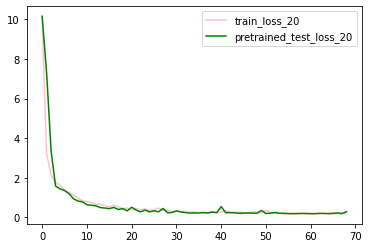

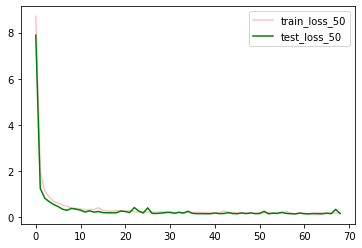

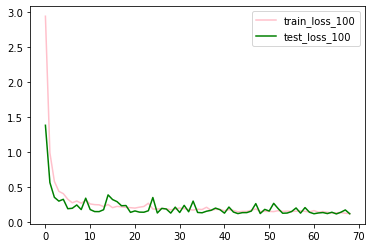

In [30]:
pyplot.figure(1)
plot_loss(losses_train_20,'train_loss_20','pink')
plot_loss(losses_test_20,'pretrained_test_loss_20','green')
pyplot.figure(2)
plot_loss(losses_train_50,'train_loss_50','pink')
plot_loss(losses_test_50,'test_loss_50','green')
pyplot.figure(3)
plot_loss(losses_train_100,'train_loss_100','pink')
plot_loss(losses_test_100,'test_loss_100','green')

Comparam acuratetea si valorile functiei de penalizare pe setul de validare:

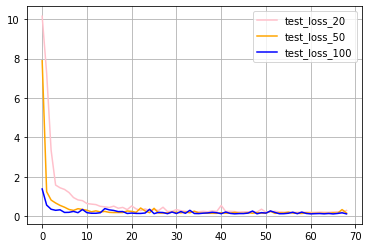

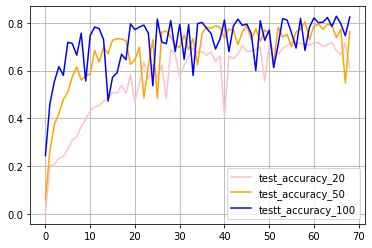

In [48]:
pyplot.figure(1)
plot_loss(losses_test_20,'test_loss_20','pink')
plot_loss(losses_test_50,'test_loss_50','orange')
plot_loss(losses_test_100,'test_loss_100','blue')
pyplot.figure(2)
plot_loss(test_accuracy_20,'test_accuracy_20','pink')
plot_loss(test_accuracy_50,'test_accuracy_50','orange')
plot_loss(test_accuracy_100,'testt_accuracy_100','blue')

Se poate observa ca, cu cat avem mai multe date, functia de pierdere este minimizata mai repede. De asemenea, acuratetea creste atunci cand avem mai multe date si converge mai repede catre valori mai mari.

Comparam mai departe cu modelele preantrenate.

Folosim utlimul model salvat pentru modelele preantrenate pe procente diferite din setul de date.

In [43]:
PATH = 'conv_net.pt'
torch.save(model.state_dict(), PATH)

Incarcam parametri modelului deja antrenat:

In [44]:
loaded_state_dict = torch.load(PATH)
model_dict = {}
for key,val in loaded_state_dict.items():
    key = key.replace('fc','fully_conv')
    print(f'key: {key}')
    if 'fully_conv1.weight' in key:
      val = val.view(-1,no_filter2,4,4)
    if 'fully_conv2.weigh' in key:
      val = val.view(-1,no_neurons1,1,1)
    model_dict[key] = val

key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias


In [45]:
# definim modelele si le initializam cu paramtri modelului convolutional
pre_count_model_20 = CNN_count()
pre_count_model_20.load_state_dict(model_dict, strict=False)
pre_count_model_20 = pre_count_model_20.to(device)

pre_count_model_50 = CNN_count()
pre_count_model_50.load_state_dict(model_dict, strict=False)
pre_count_model_50 = pre_count_model_50.to(device) 

pre_count_model_100 = CNN_count()
pre_count_model_100.load_state_dict(model_dict, strict=False)
pre_count_model_100 = pre_count_model_100.to(device)

# optimizerele
pre_optimizer_count_20 = optim.SGD(
    pre_count_model_20.parameters(), lr=1e-4, momentum=args.momentum)
pre_optimizer_count_50 = optim.SGD(
    pre_count_model_50.parameters(), lr=1e-4, momentum=args.momentum)
pre_optimizer_count_100 = optim.SGD(
    pre_count_model_100.parameters(), lr=1e-4, momentum=args.momentum)

# metricile
pre_losses_train_20, pre_losses_test_20, pre_train_accuracy_20, pre_test_accuracy_20 = training_variants(pre_count_model_20, device, large_data_loader_train_20, large_data_loader_test, pre_optimizer_count_20, 70)
pre_losses_train_50, pre_losses_test_50, pre_train_accuracy_50, pre_test_accuracy_50 = training_variants(pre_count_model_50, device, large_data_loader_train_50, large_data_loader_test, pre_optimizer_count_50, 70)
pre_losses_train_100, pre_losses_test_100, pre_train_accuracy_100, pre_test_accuracy_100 = training_variants(pre_count_model_100, device, large_data_loader_train, large_data_loader_test, pre_optimizer_count_100, 70)


Pretrained epoch: 1

Test set: Average loss: 5.3212

Train accuracy: 0.043
Test accuracy: 0.204
Pretrained epoch: 2

Test set: Average loss: 3.6900

Train accuracy: 0.19
Test accuracy: 0.225
Pretrained epoch: 3

Test set: Average loss: 1.5244

Train accuracy: 0.231
Test accuracy: 0.243
Pretrained epoch: 4

Test set: Average loss: 1.3965

Train accuracy: 0.249
Test accuracy: 0.247
Pretrained epoch: 5

Test set: Average loss: 1.4514

Train accuracy: 0.249
Test accuracy: 0.247
Pretrained epoch: 6

Test set: Average loss: 1.2825

Train accuracy: 0.265
Test accuracy: 0.26
Pretrained epoch: 7

Test set: Average loss: 1.1957

Train accuracy: 0.288
Test accuracy: 0.27
Pretrained epoch: 8

Test set: Average loss: 1.1052

Train accuracy: 0.308
Test accuracy: 0.284
Pretrained epoch: 9

Test set: Average loss: 0.9975

Train accuracy: 0.322
Test accuracy: 0.321
Pretrained epoch: 10

Test set: Average loss: 0.8851

Train accuracy: 0.36
Test accuracy: 0.346
Pretrained epoch: 11

Test set: Average los


Test set: Average loss: 0.2208

Train accuracy: 0.6252
Test accuracy: 0.689
Pretrained epoch: 18

Test set: Average loss: 0.5240

Train accuracy: 0.6308
Test accuracy: 0.447
Pretrained epoch: 19

Test set: Average loss: 0.3255

Train accuracy: 0.5388
Test accuracy: 0.576
Pretrained epoch: 20

Test set: Average loss: 0.2030

Train accuracy: 0.6392
Test accuracy: 0.702
Pretrained epoch: 21

Test set: Average loss: 0.1960

Train accuracy: 0.6552
Test accuracy: 0.718
Pretrained epoch: 22

Test set: Average loss: 0.1991

Train accuracy: 0.6636
Test accuracy: 0.702
Pretrained epoch: 23

Test set: Average loss: 0.1861

Train accuracy: 0.6692
Test accuracy: 0.726
Pretrained epoch: 24

Test set: Average loss: 0.2112

Train accuracy: 0.6924
Test accuracy: 0.699
Pretrained epoch: 25

Test set: Average loss: 0.2869

Train accuracy: 0.6808
Test accuracy: 0.614
Pretrained epoch: 26

Test set: Average loss: 0.1893

Train accuracy: 0.6784
Test accuracy: 0.728
Pretrained epoch: 27

Test set: Average l


Test set: Average loss: 0.1613

Train accuracy: 0.7218
Test accuracy: 0.756
Pretrained epoch: 33

Test set: Average loss: 0.2165

Train accuracy: 0.7198
Test accuracy: 0.691
Pretrained epoch: 34

Test set: Average loss: 0.2208

Train accuracy: 0.7226
Test accuracy: 0.683
Pretrained epoch: 35

Test set: Average loss: 0.1369

Train accuracy: 0.7146
Test accuracy: 0.785
Pretrained epoch: 36

Test set: Average loss: 0.1879

Train accuracy: 0.743
Test accuracy: 0.724
Pretrained epoch: 37

Test set: Average loss: 0.1570

Train accuracy: 0.74
Test accuracy: 0.756
Pretrained epoch: 38

Test set: Average loss: 0.1375

Train accuracy: 0.7262
Test accuracy: 0.794
Pretrained epoch: 39

Test set: Average loss: 0.1718

Train accuracy: 0.7408
Test accuracy: 0.746
Pretrained epoch: 40

Test set: Average loss: 0.1342

Train accuracy: 0.728
Test accuracy: 0.798
Pretrained epoch: 41

Test set: Average loss: 0.1381

Train accuracy: 0.7354
Test accuracy: 0.791
Pretrained epoch: 42

Test set: Average loss:

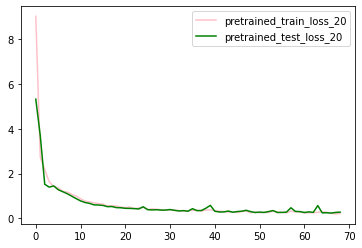

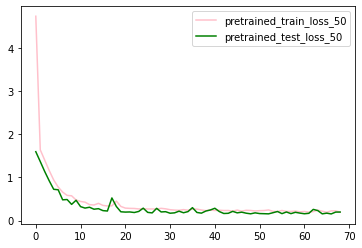

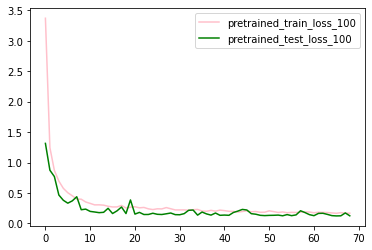

In [49]:
pyplot.figure(1)
plot_loss(pre_losses_train_20,'pretrained_train_loss_20','pink')
plot_loss(pre_losses_test_20,'pretrained_test_loss_20','green')
pyplot.figure(2)
plot_loss(pre_losses_train_50,'pretrained_train_loss_50','pink')
plot_loss(pre_losses_test_50,'pretrained_test_loss_50','green')
pyplot.figure(3)
plot_loss(pre_losses_train_100,'pretrained_train_loss_100','pink')
plot_loss(pre_losses_test_100,'pretrained_test_loss_100','green')

Si acuratetea:

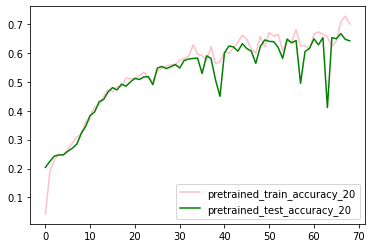

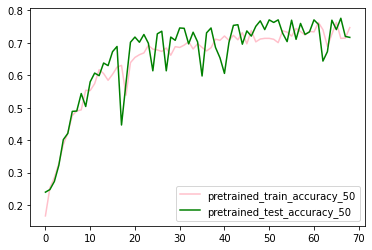

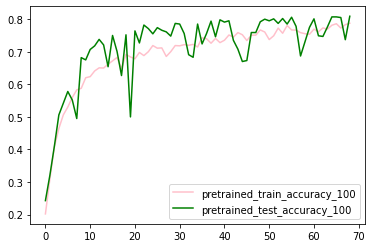

In [50]:
pyplot.figure(1)
plot_loss(pre_train_accuracy_20,'pretrained_train_accuracy_20','pink')
plot_loss(pre_test_accuracy_20,'pretrained_test_accuracy_20','green')
pyplot.figure(2)
plot_loss(pre_train_accuracy_50,'pretrained_train_accuracy_50','pink')
plot_loss(pre_test_accuracy_50,'pretrained_test_accuracy_50','green')
pyplot.figure(3)
plot_loss(pre_train_accuracy_100,'pretrained_train_accuracy_100','pink')
plot_loss(pre_test_accuracy_100,'pretrained_test_accuracy_100','green')

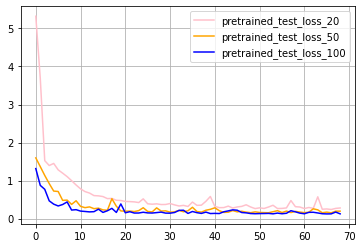

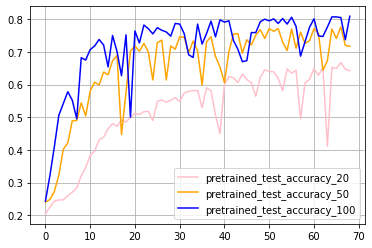

In [51]:
pyplot.figure(1)
plot_loss(pre_losses_test_20,'pretrained_test_loss_20','pink')
plot_loss(pre_losses_test_50,'pretrained_test_loss_50','orange')
plot_loss(pre_losses_test_100,'pretrained_test_loss_100','blue')
pyplot.figure(2)
plot_loss(pre_test_accuracy_20,'pretrained_test_accuracy_20','pink')
plot_loss(pre_test_accuracy_50,'pretrained_test_accuracy_50','orange')
plot_loss(pre_test_accuracy_100,'pretrained_test_accuracy_100','blue')

Observatiile asupra functiei de pierdere se mentin. In cazul acuratetei, aceasta oscileaza mai mult in functie de numarul de date decat atunci cand modelul nu avea parametri initializati (pentru mai putine date obtinem o acuratete mul mai mica pe setul de validare).

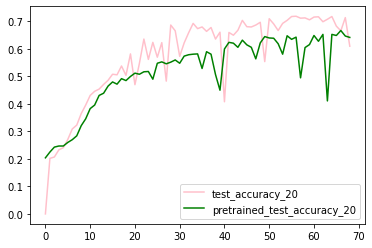

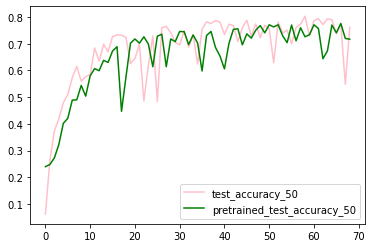

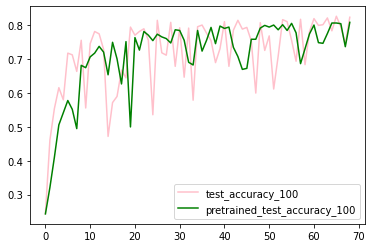

In [53]:
# Comparam acuratetea pe validare in functie de cele 3 seturi de date:
pyplot.figure(1)
plot_loss(test_accuracy_20,'test_accuracy_20','pink')
plot_loss(pre_test_accuracy_20,'pretrained_test_accuracy_20','green')
pyplot.figure(2)
plot_loss(test_accuracy_50,'test_accuracy_50','pink')
plot_loss(pre_test_accuracy_50,'pretrained_test_accuracy_50','green')
pyplot.figure(3)
plot_loss(test_accuracy_100,'test_accuracy_100','pink')
plot_loss(pre_test_accuracy_100,'pretrained_test_accuracy_100','green')

Comparand acuratetea pe validare pentru la fel de multe date pe modele initializate aleator versus modele initializate cu parametri altor retele, putem observa ca nu avem diferente foarte mari decat atunci cand avem date putine.
In ceea ce priveste stabilitatea, modelul preantrenat oscileaza mai putin ca acuratete fata de cel initializat aleator, in cazul folosirii intregului set de date.

Afisam acuratetea finala pentru toate cele 6 modele:

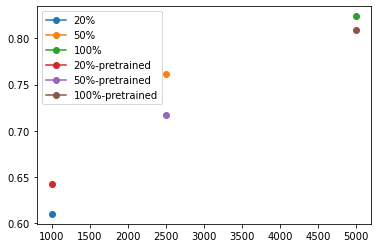

In [84]:
pyplot.plot(1000,test_accuracy_20[-1],  marker='o', label="20%")
pyplot.plot(2500,test_accuracy_50[-1],  marker='o',label="50%")
pyplot.plot(5000,test_accuracy_100[-1],  marker='o',label="100%")
pyplot.plot(1000,pre_test_accuracy_20[-1],  marker='o',label="20%-pretrained")
pyplot.plot(2500,pre_test_accuracy_50[-1],  marker='o', label="50%-pretrained")
pyplot.plot(5000,pre_test_accuracy_100[-1],  marker='o', label="100%-pretrained")
pyplot.legend()